In [2]:
# ==============================================================================
# KHAI BÁO THƯ VIỆN & CẤU HÌNH MÔI TRƯỜNG
# ==============================================================================

# 1. Thư viện hệ thống & Tiện ích cơ bản
import os
import sys
import json
import re
import time
import shutil
import pickle
import joblib
from collections import defaultdict, Counter

# 2. Thư viện xử lý dữ liệu & Tính toán
import numpy as np
import pandas as pd

# 3. Thư viện Trực quan hóa (Vẽ biểu đồ)
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Thư viện Machine Learning (Scikit-Learn)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix

# Các thuật toán ML
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# 5. Thư viện Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Input

# 6. Cấu hình hiển thị cho đẹp
# Set style cho biểu đồ seaborn
sns.set_theme(style="whitegrid")
# Hiển thị hết các cột của pandas khi in
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Kiểm tra version để chắc chắn môi trường đã cài đủ
print(f"Python version: {sys.version.split()[0]}")
print(f"TensorFlow version: {tf.__version__}")

Python version: 3.10.11
TensorFlow version: 2.20.0


In [3]:
# ==============================================================================
# ĐỊNH NGHĨA HÀM LOAD DỮ LIỆU VÀ TOKENIZER
# ==============================================================================
def load_labelstudio_json(path):
    with open(path, encoding="utf-8") as f:
        data = json.load(f)

    sentences, labels = [], []
    vocab_phrases = set()

    for task in data:
        # Lấy kết quả annotation hoặc prediction tuỳ vào dữ liệu
        results = (
            task.get("annotations", [{}])[0].get("result", []) or
            task.get("predictions", [{}])[0].get("result", [])
        )
        # Sắp xếp theo vị trí xuất hiện trong câu
        results = sorted(results, key=lambda x: x["value"]["start"])

        tokens, tags = [], []
        for r in results:
            txt = r["value"]["text"].strip()
            if not txt:
                continue
            token = txt.replace(" ", "_") # Nối từ ghép bằng gạch dưới
            tokens.append(token)
            tags.append(r["value"]["labels"][0])
            vocab_phrases.add(token.lower())

        if tokens:
            sentences.append(tokens)
            labels.append(tags)

    return sentences, labels, vocab_phrases

def gold_tokenize(sentence, phrase_vocab):
    # Tách từ đơn giản trước
    words = re.findall(r"\w+|[^\w\s]", sentence, re.UNICODE)
    words = [w for w in words if w.strip()]
    n = len(words)
    i = 0
    tokens = []

    # Thuật toán Longest Matching (Khớp từ dài nhất) dựa trên từ điển train
    while i < n:
        matched = False
        for L in range(5, 0, -1):  # Thử ghép tối đa 5 từ
            if i + L <= n:
                phrase = "_".join(words[i:i+L]).lower()
                if phrase in phrase_vocab:
                    tokens.append("_".join(words[i:i+L]))
                    i += L
                    matched = True
                    break
        if not matched:
            tokens.append(words[i])
            i += 1
    return tokens

In [4]:
# ==============================================================================
# THỰC THI LOAD DỮ LIỆU
# ==============================================================================

# Đường dẫn tới file dữ liệu Label Studio đã xuất ra
TRAIN_JSON = "combined_data.json" 

if os.path.exists(TRAIN_JSON):
    sentences, labels, PHRASE_VOCAB = load_labelstudio_json(TRAIN_JSON)
    print(f"Đã load thành công {len(sentences)} câu.")
    print(f"Đã học được {len(PHRASE_VOCAB)} cụm từ/từ vựng.")
    
    print("\nVí dụ:")
    print(sentences[4])
    print(labels[4])
else:
    print(f"KHÔNG TÌM THẤY FILE: {TRAIN_JSON}")

Đã load thành công 2099 câu.
Đã học được 5183 cụm từ/từ vựng.

Ví dụ:
['Apple', 'cũng', 'công_bố', 'danh_sách', 'game', 'nổi_bật', 'năm', '2025']
['Np', 'R', 'V', 'N', 'Vb', 'A', 'N', 'M']


In [5]:
# ==============================================================================
# TRÍCH XUẤT ĐẶC TRƯNG (FEATURE EXTRACTION) & CHIA DATA
# ==============================================================================

# Hàm trích xuất đặc trưng cho từng từ
def extract_features(sent, i):
    w = sent[i]
    return {
        "word": w,
        "is_first": i == 0,
        "is_last": i == len(sent) - 1,
        "is_cap": w[0].isupper() if len(w) > 0 else False,
        "is_upper": w.isupper(),
        "is_lower": w.islower(),
        "has_underscore": "_" in w,
        "prefix1": w[:1],
        "prefix2": w[:2],
        "suffix1": w[-1:],
        "suffix2": w[-2:],
        "prev_word": sent[i-1] if i > 0 else "",
        "next_word": sent[i+1] if i < len(sent)-1 else ""
    }

print("Đang xử lý đặc trưng (Feature Extraction)...")

# Chia tập Train/Val (80% train, 20% validation)
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

# Áp dụng hàm trích xuất đặc trưng cho toàn bộ dữ liệu
X_train = [extract_features(s, i) for s in X_train_s for i in range(len(s))]
y_train = [t for ts in y_train_s for t in ts]

X_val = [extract_features(s, i) for s in X_val_s for i in range(len(s))]
y_val = [t for ts in y_val_s for t in ts]

# Vector hóa dữ liệu (Chuyển chữ thành số)
vec = DictVectorizer()
X_train_v = vec.fit_transform(X_train)
X_val_v = vec.transform(X_val)

# Mã hóa nhãn (Label Encoding)
le = LabelEncoder()
le.fit(sorted(set(y_train + y_val)))
y_train_e = le.transform(y_train)
y_val_e = le.transform(y_val)

TAGS = le.classes_
print("Đã chuẩn bị xong dữ liệu cho mô hình Machine Learning.")
print(f"Danh sách nhãn (Tags): {TAGS}")

Đang xử lý đặc trưng (Feature Extraction)...
Đã chuẩn bị xong dữ liệu cho mô hình Machine Learning.
Danh sách nhãn (Tags): ['A' 'C' 'CH' 'Cc' 'E' 'L' 'M' 'N' 'Nb' 'Nc' 'Np' 'Nu' 'Ny' 'P' 'R' 'T'
 'V' 'Vb' 'X' 'Z']


VÍ DỤ 5 CÂU DỮ LIỆU MẪU (Sau khi Tokenize):
Câu 1:
   - Tokens: ['ChatGPT', 'được', 'tả', 'i', 'nhiều', 'nhất', 'năm', '2025', 'tại', 'Mỹ']
   - Labels: ['Np', 'V', 'V', 'V', 'A', 'R', 'N', 'M', 'E', 'Np']
--------------------------------------------------------------------------------
Câu 2:
   - Tokens: ['ChatGPT', 'dẫn_đầu', 'nhóm', 'ứng_dụng', 'miễn_phí', 'với', 'lượng_cài_đặt', 'cao', 'nhất', 'năm', '2025.']
   - Labels: ['Np', 'V', 'N', 'N', 'V', 'E', 'N', 'A', 'R', 'N', 'M']
--------------------------------------------------------------------------------
Câu 3:
   - Tokens: ['Sự', 'thống_trị', 'của', 'ChatGPT', 'thể_hiện', 'bước_nhảy_vọt', 'chỉ', 'trong', 'hai_năm']
   - Labels: ['N', 'V', 'E', 'Np', 'V', 'N', 'R', 'E', 'M']
--------------------------------------------------------------------------------
Câu 4:
   - Tokens: ['Vị_trí', 'số', '1', 'thuộc', 'về', 'ứng_dụng', 'bán', 'hàng', 'Trung_Quốc', 'Temu', '.']
   - Labels: ['N', 'N', 'M', 'V', 'E', 'N', 'V', 'N', 'Np', 'Np', 

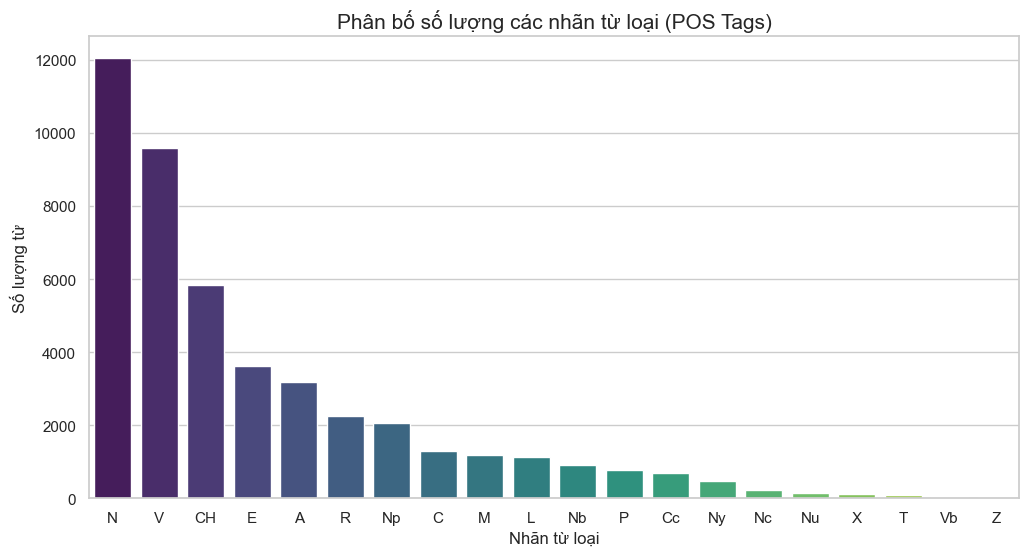


MINH HỌA QUÁ TRÌNH: TỪ VỰNG -> ĐẶC TRƯNG -> VECTOR SỐ
TỪ ĐANG XÉT: 'công_bố' (trong ngữ cảnh câu đầu tiên)

TRÍCH XUẤT ĐẶC TRƯNG (Feature Dictionary):
Máy tính phân tích từ này thành các thuộc tính sau:
  • word           : công_bố
  • is_first       : False
  • is_last        : False
  • is_cap         : False
  • is_upper       : False
  • is_lower       : True
  • has_underscore : True
  • prefix1        : c
  • prefix2        : cô
  • suffix1        : ố
  • suffix2        : bố
  • prev_word      : cũng
  • next_word      : danh_sách

VECTOR HÓA (Mapping to Numbers):
Vector kết quả có kích thước 17006 chiều.
------------------------------------------------------------
INDEX (VỊ TRÍ)  | GIÁ TRỊ    | Ý NGHĨA (TÊN ĐẶC TRƯNG TƯƠNG ỨNG)
------------------------------------------------------------
0               | 1.0        | has_underscore
4               | 1.0        | is_lower
1831            | 1.0        | next_word=danh_sách
4736            | 1.0        | prefix1=c
5380           

In [6]:
# ==============================================================================
# PHÂN TÍCH & TRỰC QUAN HÓA DỮ LIỆU
# ==============================================================================

print("VÍ DỤ 5 CÂU DỮ LIỆU MẪU (Sau khi Tokenize):")
print("=" * 80)
for i in range(min(5, len(sentences))):
    print(f"Câu {i+1}:")
    print(f"   - Tokens: {sentences[i]}")
    print(f"   - Labels: {labels[i]}")
    print("-" * 80)

# --- BIỂU ĐỒ PHÂN BỐ NHÃN ---
print("\nTHỐNG KÊ PHÂN BỐ CÁC LOẠI NHÃN:")
# Gộp tất cả các nhãn lại để đếm
all_tags = [tag for sent_tags in labels for tag in sent_tags]
tag_counts = Counter(all_tags)

df_tags = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['Count']).reset_index()
df_tags.columns = ['Tag', 'Count']
df_tags = df_tags.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_tags, x='Tag', y='Count', hue='Tag', palette='viridis', legend=False)
plt.title("Phân bố số lượng các nhãn từ loại (POS Tags)", fontsize=15)
plt.xlabel("Nhãn từ loại")
plt.ylabel("Số lượng từ")
plt.show()

# --- MINH HỌA CHI TIẾT TỪ ĐẶC TRƯNG ĐẾN VECTOR ---
print("\nMINH HỌA QUÁ TRÌNH: TỪ VỰNG -> ĐẶC TRƯNG -> VECTOR SỐ")
print("=" * 80)

sent_idx = 4
word_idx = 2 

if len(sentences) > 0 and len(sentences[sent_idx]) > word_idx:
    target_word = sentences[sent_idx][word_idx]
    
    # Trích xuất đặc trưng (Feature Extraction)
    # Gọi lại hàm extract_features cho chính xác, không lấy từ X_train phẳng
    features_dict = extract_features(sentences[sent_idx], word_idx)
    
    print(f"TỪ ĐANG XÉT: '{target_word}' (trong ngữ cảnh câu đầu tiên)")
    print("\nTRÍCH XUẤT ĐẶC TRƯNG (Feature Dictionary):")
    print("Máy tính phân tích từ này thành các thuộc tính sau:")
    for k, v in features_dict.items():
        print(f"  • {k:<15}: {v}")
        
    # Vector hóa (Vectorization)
    vector_sparse = vec.transform([features_dict])
    
    print("\nVECTOR HÓA (Mapping to Numbers):")
    print(f"Vector kết quả có kích thước {vector_sparse.shape[1]} chiều.")
    print("-" * 60)
    print(f"{'INDEX (VỊ TRÍ)':<15} | {'GIÁ TRỊ':<10} | {'Ý NGHĨA (TÊN ĐẶC TRƯNG TƯƠNG ỨNG)'}")
    print("-" * 60)
    
    # Lấy các chỉ số khác 0 (non-zero)
    non_zero_indices = vector_sparse.nonzero()[1]
    feature_names = vec.get_feature_names_out() # Lấy danh sách tên đặc trưng
    
    for idx in non_zero_indices:
        feat_name = feature_names[idx]
        print(f"{idx:<15} | {1.0:<10} | {feat_name}")

else:
    print("Dữ liệu mẫu không đủ để chạy ví dụ này.")

In [7]:
# ==============================================================================
# HUẤN LUYỆN 4 MÔ HÌNH MACHINE LEARNING
# ==============================================================================

# Dictionary để lưu kết quả
model_results = {}
trained_models = {}

def train_and_predict(model, name):
    print(f"\n- Đang huấn luyện mô hình: {name} ...")
    start_time = time.time()
    
    # Train
    model.fit(X_train_v, y_train_e)
    
    # Predict
    pred = model.predict(X_val_v)
    
    end_time = time.time()
    duration = end_time - start_time
    print(f"=> Hoàn thành sau {duration:.2f} giây.")
    
    return pred, model

# 1. SVM
pred_svm, model_svm = train_and_predict(LinearSVC(max_iter=3000), "SVM")
model_results["SVM"] = pred_svm
trained_models["SVM"] = model_svm

# 2. Logistic Regression
pred_log, model_log = train_and_predict(LogisticRegression(max_iter=1000), "Logistic Regression")
model_results["Logistic"] = pred_log
trained_models["Logistic"] = model_log

# 3. Naive Bayes
pred_nb, model_nb = train_and_predict(MultinomialNB(), "Naive Bayes")
model_results["Naive Bayes"] = pred_nb
trained_models["Naive Bayes"] = model_nb

# 4. Random Forest
pred_rf, model_rf = train_and_predict(RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest")
model_results["Random Forest"] = pred_rf
trained_models["Random Forest"] = model_rf


- Đang huấn luyện mô hình: SVM ...
=> Hoàn thành sau 11.04 giây.

- Đang huấn luyện mô hình: Logistic Regression ...
=> Hoàn thành sau 16.92 giây.

- Đang huấn luyện mô hình: Naive Bayes ...
=> Hoàn thành sau 0.04 giây.

- Đang huấn luyện mô hình: Random Forest ...
=> Hoàn thành sau 222.36 giây.


Đang tính toán và ghi chi tiết vào file 'ket_qua_chi_tiet.txt'...


c:\Users\pct2k\AppData\Local\Python\pythoncore-3.10-64\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pct2k\AppData\Local\Python\pythoncore-3.10-64\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pct2k\AppData\Local\Python\pythoncore-3.10-64\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM
      Mô hình  Accuracy  Precision  Recall  F1-Score
          SVM    0.9012     0.9009  0.9012    0.9004
     Logistic    0.8971     0.8964  0.8971    0.8956
  Naive Bayes    0.8699     0.8669  0.8699    0.8641
Random Forest    0.8922     0.8924  0.8922    0.8910
- Đã lưu chi tiết từng nhãn vào file: ket_qua_chi_tiet.txt


C:\Users\pct2k\AppData\Local\Temp\ipykernel_6080\2992681962.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Mô hình", y="Accuracy", data=df_summary, palette="viridis")


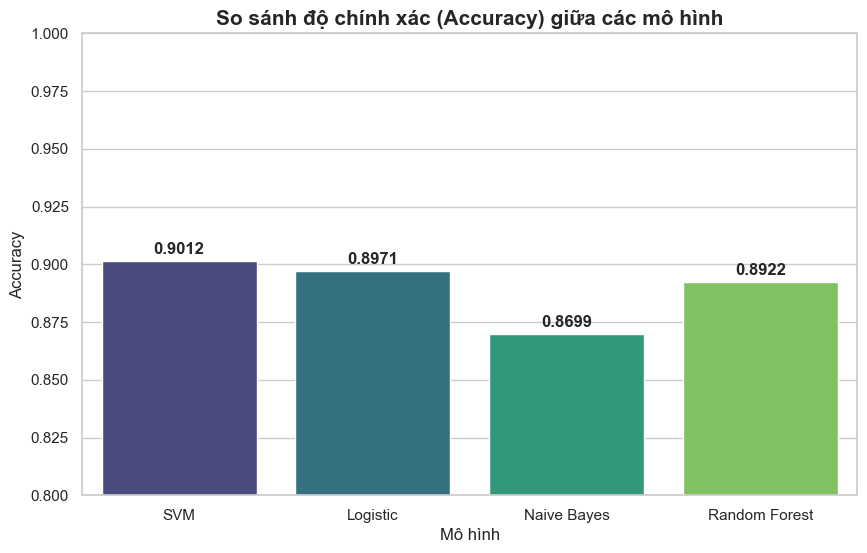

In [8]:
# ==============================================================================
# TỔNG HỢP KẾT QUẢ & XUẤT BÁO CÁO
# ==============================================================================

# Danh sách để lưu kết quả tổng hợp
summary_data = []
output_file = "ket_qua_chi_tiet.txt"

print(f"Đang tính toán và ghi chi tiết vào file '{output_file}'...")

with open(output_file, "w", encoding="utf-8") as f:
    f.write("PHỤ LỤC: KẾT QUẢ CHI TIẾT TỪNG MÔ HÌNH (FULL REPORT)\n")
    f.write("="*70 + "\n\n")

    for name, pred in model_results.items():
        # Tính các chỉ số tổng quát
        acc = accuracy_score(y_val_e, pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_val_e, pred, average='weighted', zero_division=0)
        
        # Lưu vào danh sách để tạo bảng tổng hợp
        summary_data.append({
            "Mô hình": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1
        })
        
        # Tạo báo cáo chi tiết cho từng nhãn (A, N, V,...)
        report_text = classification_report(y_val_e, pred, target_names=TAGS, digits=4)
        
        # Ghi vào file text (Để bạn copy vào phụ lục luận văn)
        f.write(f"- MÔ HÌNH: {name.upper()}\n")
        f.write(f"Độ chính xác (Accuracy): {acc:.4f}\n")
        f.write("-" * 70 + "\n")
        f.write(report_text + "\n")
        f.write("=" * 70 + "\n\n")

# --- IN BẢNG TỔNG HỢP ---
df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.round(4) # Làm tròn 4 chữ số

print("\n" + "="*80)
print("BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM")
print("="*80)
print(df_summary.to_string(index=False)) # In bảng đẹp
print("="*80)
print(f"- Đã lưu chi tiết từng nhãn vào file: {output_file}")

# --- VẼ BIỂU ĐỒ SO SÁNH ACCURACY ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Mô hình", y="Accuracy", data=df_summary, palette="viridis")

# Hiển thị số trên đầu cột
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=3, fontweight='bold')

plt.title("So sánh độ chính xác (Accuracy) giữa các mô hình", fontsize=15, fontweight='bold')
plt.ylim(0.80, 1.0)
plt.ylabel("Accuracy")
plt.show()


- Đang xây dựng và huấn luyện model Bi-LSTM...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 348ms/step - accuracy: 0.3107 - loss: 2.3292 - val_accuracy: 0.4193 - val_loss: 1.9006
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 310ms/step - accuracy: 0.5263 - loss: 1.5845 - val_accuracy: 0.6648 - val_loss: 1.1220
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 318ms/step - accuracy: 0.7904 - loss: 0.7613 - val_accuracy: 0.8369 - val_loss: 0.5772
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.8855 - loss: 0.4130 - val_accuracy: 0.8671 - val_loss: 0.4500
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 344ms/step - accuracy: 0.9118 - loss: 0.2936 - val_accuracy: 0.8682 - val_loss: 0.4156
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - accuracy: 0.9213 - loss: 0.2412 - val_accuracy: 0.8754 - val_loss: 0.3962
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 478ms/step - accuracy: 0.9268 - loss: 0.2130 - val_accuracy: 0.8745 - val_loss: 0.3994
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 445ms/s

c:\Users\pct2k\AppData\Local\Python\pythoncore-3.10-64\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pct2k\AppData\Local\Python\pythoncore-3.10-64\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pct2k\AppData\Local\Python\pythoncore-3.10-64\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


KẾT QUẢ MÔ HÌNH BI-LSTM
Mô hình  Accuracy  Precision  Recall  F1-Score
Bi-LSTM    0.8763      0.879  0.8763    0.8745

=> Đã ghi thêm kết quả Bi-LSTM vào file: ket_qua_chi_tiet.txt


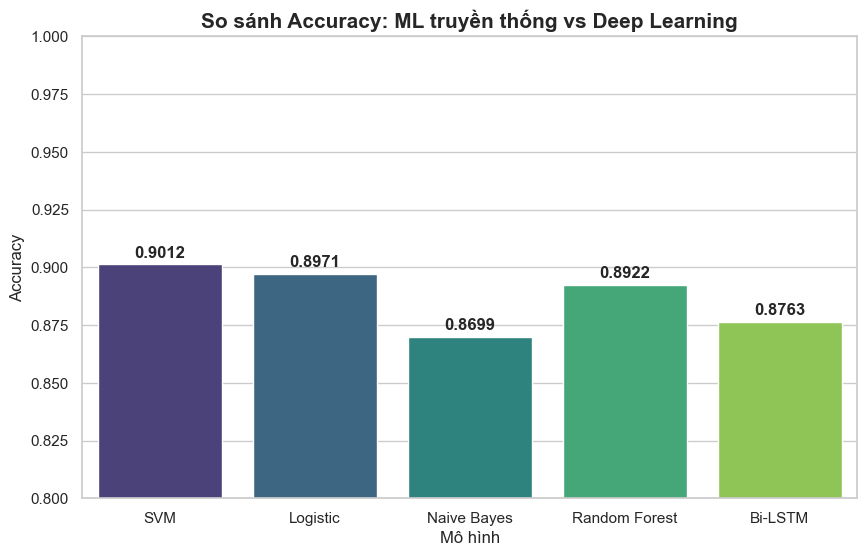

In [10]:
# ==============================================================================
# MÔ HÌNH DEEP LEARNING - BI-DIRECTIONAL LSTM
# ==============================================================================

# 1. CHUẨN BỊ DỮ LIỆU (DATA PREPARATION)
word_set = {w for s in sentences for w in s}
word2idx = {w: i+2 for i, w in enumerate(sorted(word_set))}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

tag2idx = {t: i for i, t in enumerate(TAGS)}
idx2tag = {i: t for t, i in tag2idx.items()}

MAX_LEN = max(len(s) for s in sentences)
VOCAB_SIZE = len(word2idx)
NUM_TAGS = len(TAGS)

def prepare_lstm_data(sents, tags):
    X = [[word2idx.get(w, 1) for w in s] for s in sents]
    y = [[tag2idx[t] for t in ts] for ts in tags]
    X = pad_sequences(X, maxlen=MAX_LEN, padding="post", dtype="int32")
    y = pad_sequences(y, maxlen=MAX_LEN, padding="post", dtype="int32")
    y = to_categorical(y, num_classes=NUM_TAGS).astype("float32")
    return X, y

Xtr_lstm, ytr_lstm = prepare_lstm_data(X_train_s, y_train_s)
Xva_lstm, yva_lstm = prepare_lstm_data(X_val_s, y_val_s)

# 2. XÂY DỰNG & HUẤN LUYỆN (TRAINING)
print("\n- Đang xây dựng và huấn luyện model Bi-LSTM...")
bilstm = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    TimeDistributed(Dense(NUM_TAGS, activation="softmax"))
])

bilstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Bạn có thể tăng epochs lên 10 hoặc 20 để kết quả tốt hơn
history = bilstm.fit(Xtr_lstm, ytr_lstm, validation_data=(Xva_lstm, yva_lstm), 
                     batch_size=32, epochs=10, verbose=1)

# 3. ĐÁNH GIÁ & XỬ LÝ KẾT QUẢ (EVALUATION)
print("\n- Đánh giá Bi-LSTM và tổng hợp báo cáo...")
y_pred_probs = bilstm.predict(Xva_lstm, verbose=0)

y_true_flat, y_pred_flat = [], []
for i in range(len(X_val_s)):
    sent_len = len(X_val_s[i])
    for j in range(sent_len):
        y_true_flat.append(idx2tag[np.argmax(yva_lstm[i][j])])
        y_pred_flat.append(idx2tag[np.argmax(y_pred_probs[i][j])])

# Tính toán các chỉ số
acc_lstm = accuracy_score(y_true_flat, y_pred_flat)
prec, rec, f1, _ = precision_recall_fscore_support(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

# Tạo bảng kết quả cho riêng Bi-LSTM
lstm_summary = pd.DataFrame([{
    "Mô hình": "Bi-LSTM",
    "Accuracy": acc_lstm,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}]).round(4)

# 4. GHI NỐI VÀO FILE BÁO CÁO (APPEND TO FILE)
output_file = "ket_qua_chi_tiet.txt"
with open(output_file, "a", encoding="utf-8") as f:
    report_text = classification_report(y_true_flat, y_pred_flat, digits=4)
    f.write(f"MÔ HÌNH: BI-LSTM (DEEP LEARNING)\n")
    f.write(f"Độ chính xác (Accuracy): {acc_lstm:.4f}\n")
    f.write("-" * 70 + "\n")
    f.write(report_text + "\n")
    f.write("=" * 70 + "\n\n")

# 5. HIỂN THỊ KẾT QUẢ & SO SÁNH VỚI CÁC MÔ HÌNH TRUYỀN THỐNG
print("\n" + "="*80)
print("KẾT QUẢ MÔ HÌNH BI-LSTM")
print("="*80)
print(lstm_summary.to_string(index=False))
print(f"\n=> Đã ghi thêm kết quả Bi-LSTM vào file: {output_file}")

# Thử gộp với kết quả cũ để vẽ biểu đồ tổng thể
try:
    if 'df_summary' in globals():
        # Đổi tên cột cho khớp nếu cần, hoặc tạo mới dataframe chuẩn
        df_old = df_summary[['Mô hình', 'Accuracy']].copy()
        df_new = lstm_summary[['Mô hình', 'Accuracy']].copy()
        
        # Gộp 2 bảng lại
        df_final_compare = pd.concat([df_old, df_new], ignore_index=True)
        
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x="Mô hình", y="Accuracy", data=df_final_compare, palette="viridis")
        for i in ax.containers:
            ax.bar_label(i, fmt='%.4f', padding=3, fontweight='bold')
        
        plt.title("So sánh Accuracy: ML truyền thống vs Deep Learning", fontsize=15, fontweight='bold')
        plt.ylim(0.80, 1.0)
        plt.ylabel("Accuracy")
        plt.show()
except Exception as e:
    print("(Không thể vẽ biểu đồ so sánh gộp.)")

In [11]:
# ==============================================================================
# CHẠY DỰ ĐOÁN TRÊN FILE EXCEL & XUẤT JSON
# ==============================================================================

TEST_PATH = "DATA TEST POS TAGGING.xlsx" 
# Tên file JSON đầu ra
OUT_JSON = "TEST_POS_SVM_GOLD.json"

if os.path.exists(TEST_PATH):
    print(f"- Đang đọc file Excel: {TEST_PATH} ...")
    df_test = pd.read_excel(TEST_PATH)
    
    # Tìm cột chứa câu (thường có chữ 'sentence')
    sentence_col = [c for c in df_test.columns if 'sentence' in c.lower()]
    
    if sentence_col:
        print("- Đang huấn luyện lại SVM trên TOÀN BỘ dữ liệu (Train + Val) để tối ưu...")
        # Gộp dữ liệu train và val lại để học được nhiều nhất có thể
        X_full = [extract_features(s, i) for s in sentences for i in range(len(s))]
        y_full = [t for ts in labels for t in ts]
        
        vec_full = DictVectorizer()
        X_full_v = vec_full.fit_transform(X_full)
        
        # Train lại model cuối cùng
        svm_final = LinearSVC(max_iter=3000)
        svm_final.fit(X_full_v, le.transform(y_full))
        
        # Bắt đầu dự đoán
        sentences_test = df_test[sentence_col[0]].astype(str).tolist()
        json_output = []
        print(f"\nĐang gán nhãn cho {len(sentences_test)} câu mới...")

        for idx, raw in enumerate(sentences_test):
            tokens = gold_tokenize(raw, PHRASE_VOCAB)
            if not tokens: continue
            
            feats = [extract_features(tokens, i) for i in range(len(tokens))]
            preds = le.inverse_transform(svm_final.predict(vec_full.transform(feats)))

            # Chuẩn bị format cho Label Studio
            cursor = 0
            results = []
            for w, t in zip(tokens, preds):
                w_clean = w.replace("_", " ")
                start = raw.find(w_clean, cursor)
                if start == -1: continue # Bỏ qua nếu lỗi tìm kiếm
                end = start + len(w_clean)
                cursor = end
                results.append({
                    "value": {"start": start, "end": end, "text": w_clean, "labels": [t]},
                    "from_name": "label", "to_name": "text", "type": "labels", "origin": "prediction"
                })

            json_output.append({
                "data": {"text": raw},
                "predictions": [{
                    "model_version": "SVM_GOLD_FINAL",
                    "score": 1.0,
                    "result": results
                }]
            })
            
            # In thử 5 câu đầu tiên xem kết quả
            if idx < 5:
                tagged_sent = " ".join([f"{w}/{t}" for w, t in zip(tokens, preds)])
                print(f"{idx+1}. {tagged_sent}")

        # Lưu file
        with open(OUT_JSON, "w", encoding="utf-8") as f:
            json.dump(json_output, f, ensure_ascii=False, indent=2)

        
    else:
        print("Không tìm thấy cột nào tên là 'sentence' trong file Excel.")
else:
    print(f"KHÔNG TÌM THẤY FILE EXCEL: {TEST_PATH}")

- Đang đọc file Excel: DATA TEST POS TAGGING.xlsx ...
- Đang huấn luyện lại SVM trên TOÀN BỘ dữ liệu (Train + Val) để tối ưu...

Đang gán nhãn cho 120 câu mới...
1. Không/R bao_giờ/P là/V quá/R muộn/A để/E tham_gia/V cuộc_chơi/N AI/Ny ./CH
2. Người/Nc đến/V sau/N có_thể/R tạo_ra/V những/L đột_phá/N bằng/E cách/N học/V từ/E bài_học/N của/E người/N đi/V trước/A ,/CH áp_dụng/V công_nghệ_mới/N nhất/R ./CH
3. Tuy_nhiên/C theo/E ông/Nc Zapolsky/Np ,/CH thách_thức/N lớn/A nhất/R của/E Việt_Nam/Np là/V thiếu/V dữ_liệu/N ngôn_ngữ/N và/Cc nhân_lực/N AI/Ny chuyên_sâu/A ./CH
4. Ông/Nc dẫn/V ví_dụ/N ,/CH các/L mô_hình_ngôn_ngữ/N lớn/A cần/V ngữ_liệu/N phong_phú/A cho/E cả/P tiếng/N Kinh/Np lẫn/Cc các/L phương_ngữ/N ./CH
5. Linagora/Np mong_muốn/V phối_hợp/V cùng/Cc các/L trường_đại_học/N trong_nước/A để/E thu_thập/V và/Cc chuẩn_hóa/V nguồn/N dữ_liệu/N này/P ./CH


In [12]:
# ==============================================================================
# LƯU TRỮ TÀI NGUYÊN (UPDATED)
# ==============================================================================

import os
import pickle
import joblib
import json
import shutil
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# 1. TẠO THƯ MỤC
RES_DIR = "deployment_resources"
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)
    print(f"✅ Đã tạo thư mục: {RES_DIR}")

print("\n🚀 ĐANG LƯU TRỮ TÀI NGUYÊN CHO DEPLOYMENT...")

# --- A. Full Data Training (Cho ML Models) ---
print("⏳ Chuẩn bị dữ liệu Full (Train + Val)...")
X_full = [extract_features(s, i) for s in sentences for i in range(len(s))]
y_full = [t for ts in labels for t in ts]
vec_full = DictVectorizer()
X_full_v = vec_full.fit_transform(X_full)

# --- B. Lưu Pre-processors ---
with open(os.path.join(RES_DIR, "phrase_vocab.pkl"), "wb") as f:
    pickle.dump(PHRASE_VOCAB, f)
joblib.dump(vec_full, os.path.join(RES_DIR, "vec_full.joblib"))
joblib.dump(le, os.path.join(RES_DIR, "label_encoder.joblib"))
print("✅ Đã lưu Vocab, Vectorizer, LabelEncoder")

# --- C. Lưu 4 Model Machine Learning ---

# 1. SVM
print("⏳ Saving SVM...")
svm_deploy = LinearSVC(max_iter=3000)
svm_deploy.fit(X_full_v, le.transform(y_full))
joblib.dump(svm_deploy, os.path.join(RES_DIR, "svm_final.joblib"))

# 2. Logistic
print("⏳ Saving Logistic...")
logreg_deploy = LogisticRegression(max_iter=1000)
logreg_deploy.fit(X_full_v, le.transform(y_full))
joblib.dump(logreg_deploy, os.path.join(RES_DIR, "logreg_final.joblib"))

# 3. Naive Bayes
print("⏳ Saving Naive Bayes...")
nb_deploy = MultinomialNB()
nb_deploy.fit(X_full_v, le.transform(y_full))
joblib.dump(nb_deploy, os.path.join(RES_DIR, "nb_final.joblib"))

# 4. Random Forest
print("⏳ Saving Random Forest...")
rf_deploy = RandomForestClassifier(n_estimators=100, random_state=42)
rf_deploy.fit(X_full_v, le.transform(y_full))
joblib.dump(rf_deploy, os.path.join(RES_DIR, "rf_final.joblib"))
print("✅ Đã lưu 4 mô hình Machine Learning")

# --- D. Lưu Deep Learning Metadata & Model (QUAN TRỌNG) ---
# 1. Lưu Metadata
with open(os.path.join(RES_DIR, "word2idx.json"), "w", encoding="utf-8") as f:
    json.dump(word2idx, f, ensure_ascii=False)
with open(os.path.join(RES_DIR, "tag2idx.json"), "w", encoding="utf-8") as f:
    json.dump(tag2idx, f, ensure_ascii=False)
with open(os.path.join(RES_DIR, "max_len.json"), "w", encoding="utf-8") as f:
    json.dump({"MAX_LEN": MAX_LEN}, f)

# Lưu ý: Biến 'bilstm' phải là tên biến model bạn đã train ở các cell trước
print("⏳ Saving Bi-LSTM model (.h5)...")
bilstm.save(os.path.join(RES_DIR, "bilstm.h5"))
print("✅ Đã lưu Bi-LSTM model và Metadata")

✅ Đã tạo thư mục: deployment_resources

🚀 ĐANG LƯU TRỮ TÀI NGUYÊN CHO DEPLOYMENT...
⏳ Chuẩn bị dữ liệu Full (Train + Val)...
✅ Đã lưu Vocab, Vectorizer, LabelEncoder
⏳ Saving SVM...
⏳ Saving Logistic...
⏳ Saving Naive Bayes...
⏳ Saving Random Forest...
✅ Đã lưu 4 mô hình Machine Learning


⏳ Saving Bi-LSTM model (.h5)...
✅ Đã lưu Bi-LSTM model và Metadata
